In [1]:
from pprint import pp
from typing import Counter

import pandas as pd
from matplotlib import pyplot as plt
import nltk

nltk.download('stopwords', download_dir='.env/nltk_data')

TRAIN_PATH = "absc_data/train.csv"
TEST_PATH = "absc_data/test.csv"

[nltk_data] Downloading package stopwords to .env/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read train data and test data.

In [2]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [3]:
train.head(10)

,Unnamed: 0,id,Sentence,Aspect Term,Polarity,Category
0,5911,292,I went with 5 friends and we lingered at the t...,table,neutral,Restaurant
1,1867,32,"First, it does not have a push button to open ...",lid,neutral,Laptop
2,5680,474,"Save your money and don't waste your calories,...",service,positive,Restaurant
3,2918,954,After passing by this restaurant for sometime ...,dinner,neutral,Restaurant
4,2885,1971,The sides were ok and incredibly salty.,sides,negative,Restaurant
5,1747,1716,There was a little difficulty doing the migrat...,iBook,neutral,Laptop
6,2091,2854,"Then just the other day, my left ""mouse"" butto...","left ""mouse"" button",negative,Laptop
7,5684,3662,The service was attentive without being overbe...,cod with pineapple tempura,positive,Restaurant
8,4831,657,"Always popular, always full, always a wait.",wait,negative,Restaurant
9,1094,2497,BUT there's this application called Boot Camp ...,Windows,neutral,Laptop


In [4]:
test.head(10)

,Unnamed: 0,id,Sentence,Aspect Term,Polarity,Category
0,4876,1305,"In fact, while leaving the place we saw two pe...",menu,neutral,Restaurant
1,3114,1293,"Their calzones are horrific, bad, vomit-induci...",calzones,negative,Restaurant
2,3518,228,We had champagne and caviar and felt like prin...,champagne,positive,Restaurant
3,2299,2595,Keyboard was also very nice and had a solid feel.,Keyboard,positive,Laptop
4,1694,2507,"PC users work in Word, while Mac users work in...",Word,neutral,Laptop
5,3842,1436,"my picks: Guizhou chicken, fish with hot bean ...",fish fillet in spicy source,positive,Restaurant
6,476,2778,"The screen is a little glary, and I hated the ...",screen,negative,Laptop
7,2117,2781,The speakers are terrible and are probably the...,speakers,negative,Laptop
8,3074,272,Pair you food with the excellent beers on tap ...,priced,positive,Restaurant
9,5688,1192,"They sell special sushi, everything have a top...",sushi,positive,Restaurant


### Part A

1. Find the 5 most frequently occurring aspects in the training set for each category (`restaurant` and `laptop`) and visualize the data (category and frequency) using a bar graph (use matplotlib library). You should have 2 bar graphs (one for each category).

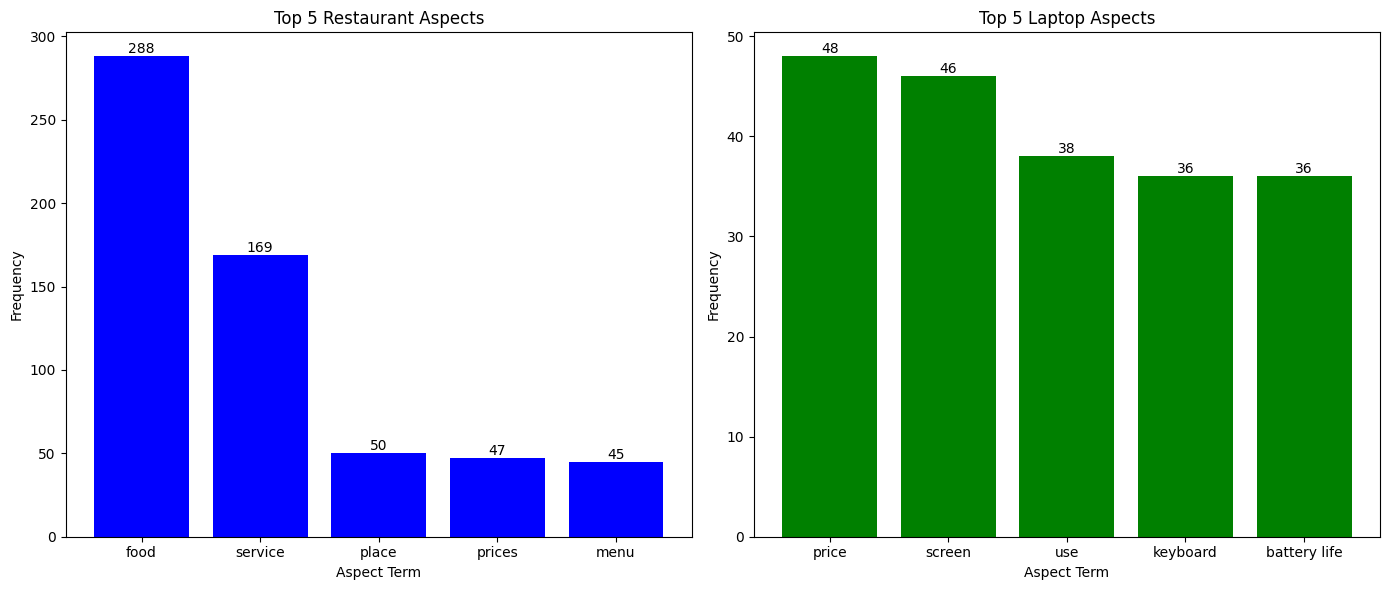

In [5]:
# Filter the data for each category
restaurant_aspects = train[train['Category'] == 'Restaurant']['Aspect Term']
laptop_aspects = train[train['Category'] == 'Laptop']['Aspect Term']

# Count the frequency of each aspect term
restaurant_aspect_counts = Counter(restaurant_aspects)
laptop_aspect_counts = Counter(laptop_aspects)

# Get the 5 most common aspects for each category
top_5_restaurant_aspects = restaurant_aspect_counts.most_common(5)
top_5_laptop_aspects = laptop_aspect_counts.most_common(5)

# Separate the aspect terms and their counts for plotting
restaurant_aspects, restaurant_counts = zip(*top_5_restaurant_aspects)
laptop_aspects, laptop_counts = zip(*top_5_laptop_aspects)

# Plot the bar graphs
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Restaurant aspects bar graph
axes[0].bar(restaurant_aspects, restaurant_counts, color='blue')
axes[0].set_title('Top 5 Restaurant Aspects')
axes[0].set_xlabel('Aspect Term')
axes[0].set_ylabel('Frequency')

# add counts over the bars
for i, count in enumerate(restaurant_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Laptop aspects bar graph
axes[1].bar(laptop_aspects, laptop_counts, color='green')
axes[1].set_title('Top 5 Laptop Aspects')
axes[1].set_xlabel('Aspect Term')
axes[1].set_ylabel('Frequency')

# add counts over the bars
for i, count in enumerate(laptop_counts):
    axes[1].text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

2) Find the distribution of the number of aspects per sentence (the same sentence can contain multiple aspects) in the entire training set and visualize the data using a bar graph. You can check for sentences having 1, 2, 3 and more than 3 aspects. You should have a single bar graph.

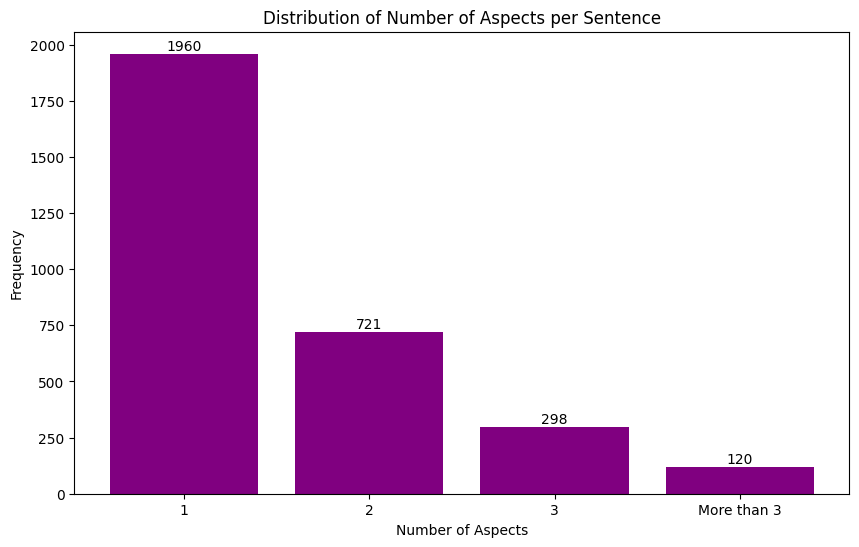

In [6]:
# Group by sentence and count the number of aspects per sentence
aspect_counts_per_sentence = train.groupby('Sentence')['Aspect Term'].count()

# Categorize the counts
aspect_distribution = aspect_counts_per_sentence.apply(
    lambda x: '1' if x == 1 else ('2' if x == 2 else ('3' if x == 3 else 'More than 3')))

# Count the frequency of each category
aspect_distribution_counts = aspect_distribution.value_counts().sort_index()

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(aspect_distribution_counts.index,
        aspect_distribution_counts.values, color='purple')
plt.title('Distribution of Number of Aspects per Sentence')
plt.xlabel('Number of Aspects')
plt.ylabel('Frequency')

# add counts over the bars
for i, count in enumerate(aspect_distribution_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### Part B

1. Support Vector Machine (SVM) based sentiment classifier

Best Model Parameters:
{'svc__C': 3, 'svc__kernel': 'rbf'}

Test Set Performance:
              precision    recall  f1-score   support

    conflict       0.33      0.18      0.23        17
    negative       0.69      0.69      0.69       338
     neutral       0.60      0.44      0.51       228
    positive       0.78      0.86      0.82       628

    accuracy                           0.73      1211
   macro avg       0.60      0.54      0.56      1211
weighted avg       0.71      0.73      0.72      1211



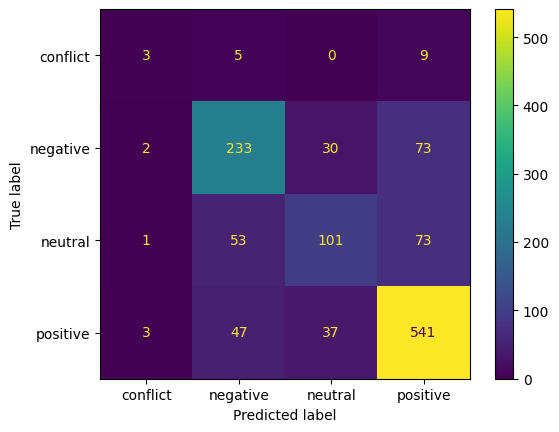

In [12]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


# Preprocessing
def concatenate_aspect_sentence(row: pd.DataFrame) -> str:
    return f"{row['Aspect Term']} [SEP] {row['Sentence']}"


train['Input'] = train.apply(concatenate_aspect_sentence, axis=1)
test['Input'] = test.apply(concatenate_aspect_sentence, axis=1)

X_train = train['Input']
y_train = train['Polarity']
X_test = test['Input']
y_test = test['Polarity']

# Model Creation
pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words=stopwords.words('english'),
        max_features=5000,
    ),
    SVC(),
)

# Hyperparameter Optimization
param_grid = {
    'svc__C': [i*j
               for i in [0.1, 1, 10]
               for j in [1, 3]
               ],
    'svc__kernel': ['linear', 'rbf'],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model Training
best_model = grid_search.best_estimator_
print("Best Model Parameters:")
pp(grid_search.best_params_)
best_model.fit(X_train, y_train)

# Model Evaluation
y_pred_test = best_model.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_test))

# print confusion matrix
cm_disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)